# Laburo con los datos experimentales

El objetivo de éste notebook es trabajar con los resultados experimentales (generados con `exp_k_alpha.py`). El código que genera los gráficos disponibles en el informe debería estar en su completitud aquí.

Primero que todo tenemos que cargar los datos experimentales:

In [1]:
from pickle import load
from gzip import open as zopen

with zopen('data.pickle.gz') as file:
    df = load(file)

df_knnpca = df[df['kind'] == 'knnpca']
df_knn = df[df['kind'] == 'knn']

print(f'Hay {len(df_knnpca)} corridas usando KNN + PCA')
print(f'Hay {len(df_knn)} corridas usando KNN a secas')

Hay 4500 corridas usando KNN + PCA
Hay 150 corridas usando KNN a secas


Hecho ésto, podemos empezar a explorar los datos usando las bibliotecas de python de siempre.

# Mejoras posibles a kNN

kNN puede usar otras estructuras de datos para acelerar el tiempo que tardamos en evaluar nuestros modelos. En éste caso utilizaremos la implementación de kNN de la biblioteca `sklearn` en lugar de la nuestra (de esta manera esperamos que las diferencias de tiempo recaigan en la elección de estructuras en lugar de en nuestras capacidades cómo programadores).

Para ésta parte de la experimentación compararemos los tiempos de los modelos utilizando búsqueda exhaustiva (igual que en nuestra implementación) y árboles k-dimensionales.

In [2]:
# Vamos a necesitar algunos datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('../data/train.csv')
data_X = data[data.columns[1:]].values
data_y = data["label"].values.reshape(-1, 1)

# Separémoslos sencillamente en un conjunto de entrenamiento y uno de evaluación
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.4)

In [3]:
from sklearn.neighbors import KNeighborsClassifier

# 1. Veamos la documentación oficial:
?KNeighborsClassifier

Init signature:
KNeighborsClassifier(
    n_neighbors=5,
    *,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None,
)
Docstring:     
Classifier implementing the k-nearest neighbors vote.

Read more in the :ref:`User Guide <classification>`.

Parameters
----------
n_neighbors : int, default=5
    Number of neighbors to use by default for :meth:`kneighbors` queries.

weights : {'uniform', 'distance'} or callable, default='uniform'
    Weight function used in prediction.  Possible values:

    - 'uniform' : uniform weights.  All points in each neighborhood
      are weighted equally.
    - 'distance' : weight points by the inverse of their distance.
      in this case, closer neighbors of a query point will have a
      greater influence than neighbors which are further away.
    - [callable] : a user-defined function which accepts an
      array of distances, and returns an array of the same shape
     

## Corramos un par de experimentos

O carguémoslos del archivo con los resultados que está cómodamente ubicado en el repo :)

En caso de querer ejecutar la experimentación alcanza con cambiar `LOAD_FROM_FILE` a `False`. Con eso se van a entrenar 5 modelos utilizando el algorithmo `kd_tree` y 5 modelos utilizando `brute` por cada $\alpha \in [5; 200] \wedge \alpha \text{ mod } 5 = 0$.

Se registran sólo los tiempos de _predict_.

In [4]:
from time import perf_counter_ns
from metnum import PCA

y_train_1d = y_train.ravel()

ALPHA_RANGE = range(5, 201, 5)
NUM_TRIES = 5
LOAD_FROM_FILE = True

def time_for(fn, *args, **kwargs):
    start_time = perf_counter_ns()
    fn(*args, **kwargs)
    end_time = perf_counter_ns()
    return end_time - start_time

if LOAD_FROM_FILE:
    with open('kd_tree_vs_brute.pickle', 'rb') as file:
        results = load(file)
else:
    results_kd_tree = {}
    results_brute = {}
    results = {
        'kd_tree': results_kd_tree,
        'brute': results_brute
    }

    for alpha in ALPHA_RANGE:
        # Primero achiquemos la dimensionalidad del problema así no tarda mil años
        pca = PCA(alpha)
        pca.fit(X_train)
        X_train_pc = pca.transform(X_train)
        X_test_pc = pca.transform(X_test)

        results_for_this_alpha_kd_tree = results_kd_tree.setdefault(alpha, [])
        results_for_this_alpha_brute = results_brute.setdefault(alpha, [])

        # Ok, queremos comparar algorithm='kd_tree' con algorithm='brute'
        knn_kd_tree = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
        knn_kd_tree.fit(X_train_pc, y_train_1d)
        knn_brute = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
        knn_brute.fit(X_train_pc, y_train_1d)

        for _ in range(NUM_TRIES):
            results_for_this_alpha_kd_tree.append(time_for(knn_kd_tree.predict, X_test_pc))
            results_for_this_alpha_brute.append(time_for(knn_brute.predict, X_test_pc))

    with open('kd_tree_vs_brute.pickle', 'wb') as file:
        from pickle import dump
        dump(results, file)

df_results = pd.DataFrame(((algo, alpha, time)
                           for algo, alpha_dict in results.items()
                           for alpha, timing_list in alpha_dict.items()
                           for time in timing_list),
                          columns=['Algoritmo', 'alpha', 'Tiempo (en segundos)'])
df_results['Tiempo (en segundos)'] /= 10**9 # Pasamos de nanosegundos a segundos
df_results

,Algoritmo,alpha,Tiempo (en segundos)
0,kd_tree,5,0.455152
1,kd_tree,5,0.459383
2,kd_tree,5,0.467578
3,kd_tree,5,0.452955
4,kd_tree,5,0.447630
...,...,...,...
395,brute,200,8.706522
396,brute,200,8.771624
397,brute,200,8.757737
398,brute,200,8.821027


Con los datos que tenemos podemos comprar `kd_tree` con `brute` y ver cómo los algoritmos se comportan para distintos valores de $\alpha$.

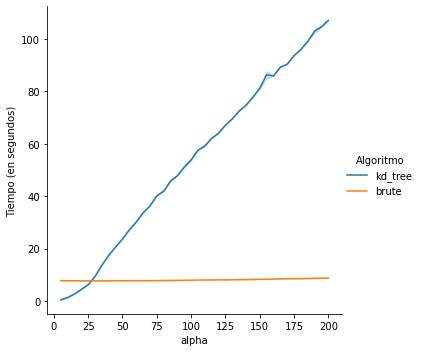

In [5]:
grid = sns.relplot(data=df_results, x='alpha', y='Tiempo (en segundos)', hue='Algoritmo', kind='line')
grid.figure.savefig('sklearn-kd-tree-vs-brute.pdf')

Ahora comparemos nuestro `brute` con el de `sklearn` :)

In [6]:
from metnum import KNNClassifier

LOAD_FROM_FILE = True

if LOAD_FROM_FILE:
    with open('kd_tree_vs_ours.pickle', 'rb') as file:
        results_sklearn_vs_ours = load(file)
else:
    results_sklearn_vs_ours = []

    for alpha in range(5, 51, 5):
        print(f'alpha={alpha} ', flush=True)
        # Primero achiquemos la dimensionalidad del problema así no tarda mil años
        pca = PCA(alpha)
        pca.fit(X_train)
        X_train_pc = pca.transform(X_train)
        X_test_pc = pca.transform(X_test)

        knn_ours = KNNClassifier(5)
        knn_ours.fit(X_train_pc, y_train_1d)
        knn_sklearn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
        knn_sklearn.fit(X_train_pc, y_train_1d)

        for _ in range(NUM_TRIES):
            print('.', end='', flush=True)
            results_sklearn_vs_ours.append(('ours', alpha, time_for(knn_ours.predict, X_test_pc)))
            print(',', end='', flush=True)
            results_sklearn_vs_ours.append(('sklearn', alpha, time_for(knn_sklearn.predict, X_test_pc)))

    results_sklearn_vs_ours = pd.DataFrame(results_sklearn_vs_ours, columns=['Implementación', 'alpha', 'Tiempo (en segundos)'])
    results_sklearn_vs_ours['Tiempo (en segundos)'] /= 10**9

    with open('kd_tree_vs_ours.pickle', 'wb') as file:
        from pickle import dump
        dump(results_sklearn_vs_ours, file)

results_sklearn_vs_ours

,Implementación,alpha,Tiempo (en segundos)
0,ours,5,2.770753
1,sklearn,5,7.861581
2,ours,5,2.770436
3,sklearn,5,7.721038
4,ours,5,2.766620
...,...,...,...
95,sklearn,50,7.665190
96,ours,50,18.684645
97,sklearn,50,7.658959
98,ours,50,18.667993


Nuevamente, tenemos los resultados, vamos a verlos.

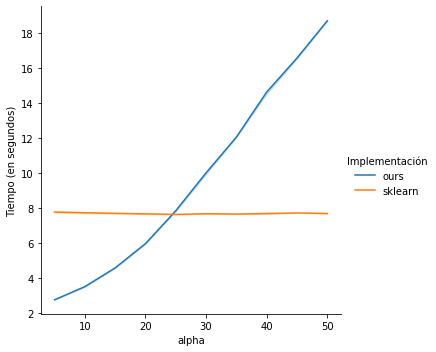

In [7]:
grid = sns.relplot(data=results_sklearn_vs_ours, x='alpha', y='Tiempo (en segundos)', hue='Implementación', kind='line')
grid.figure.savefig('brute-sklearn-vs-own.pdf')

Finalmente, veamos cómo se comporta nuestra implementación (en la experimentación de `exp_k_alpha.py`) al variar $k$.

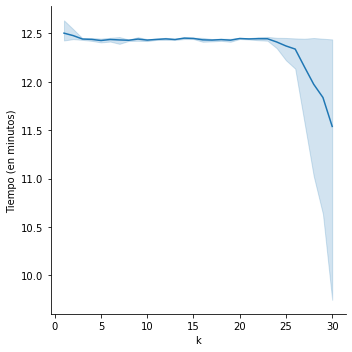

In [8]:
data = df_knn[['k', 'knn_predict_time']].copy()
data['knn_predict_time'] /= 10**9 * 60
data.columns = ['k', 'Tiempo (en minutos)']
sns.relplot(data=data, x='k', y='Tiempo (en minutos)', kind='line') \
   .figure.savefig('knn-k-performance.pdf')

¿Y al variar $\alpha$?

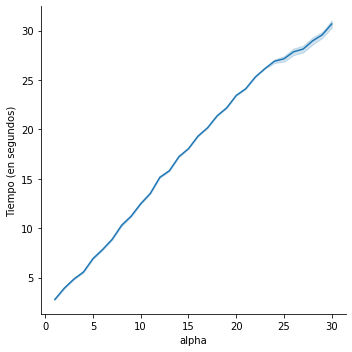

In [9]:
data = df_knnpca[['alpha', 'knn_predict_time']].copy()
data['knn_predict_time'] /= 10**9
data.columns = ['alpha', 'Tiempo (en segundos)']
sns.relplot(data=data, x='alpha', y='Tiempo (en segundos)', kind='line') \
   .figure.savefig('knnpca-alpha-performance.pdf')